In [1]:
import pytorch_lightning as pl
import torch

from src.model.cnn_m5 import CNN_M5
from src.model.lit_wrapper import LitWrapper
from src.speech_command_dataset import SpeechCommandDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} Backend!")

ds = SpeechCommandDataset(batch_size=128)
train_dl, val_dl, test_dl = ds.dls(num_workers=4)

model = LitWrapper(CNN_M5(len(ds.classes)), ds.classes, lr=0.01)

trainer = pl.Trainer(
    max_epochs=2,
    limit_train_batches=192,
    limit_val_batches=128,
    limit_predict_batches=1,
    # fast_dev_run=True
)

trainer.fit(model, train_dataloaders=train_dl, val_dataloaders=val_dl)
pred = trainer.predict(model, dataloaders=test_dl)

Using cuda Backend!


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\johnc\anaconda3\envs\snn_voice\lib\site-packages\pytorch_lightning\trainer\trainer.py:1764: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
`Trainer(limit_predict_batches=1)` was configured so 1 batch will be used.

  | Name  | Type   | Params
---------------------------------
0 | model | CNN_M5 | 26.9 K
---------------------------------
26.9 K    Trainable params
0         Non-trainable params
26.9 K    Total params
0.108     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


Predicting: 192it [00:00, ?it/s]

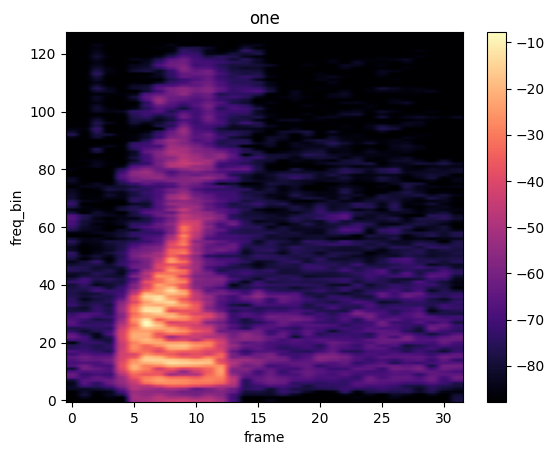

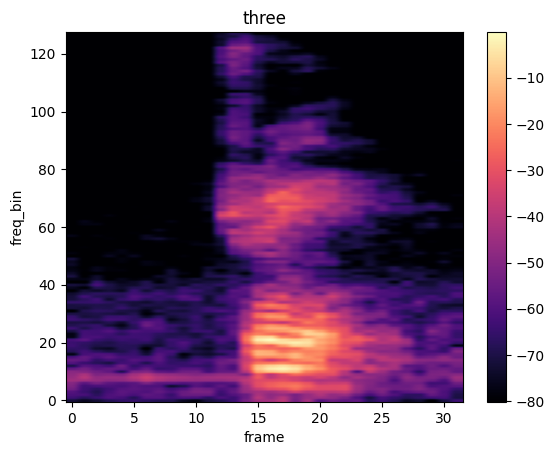

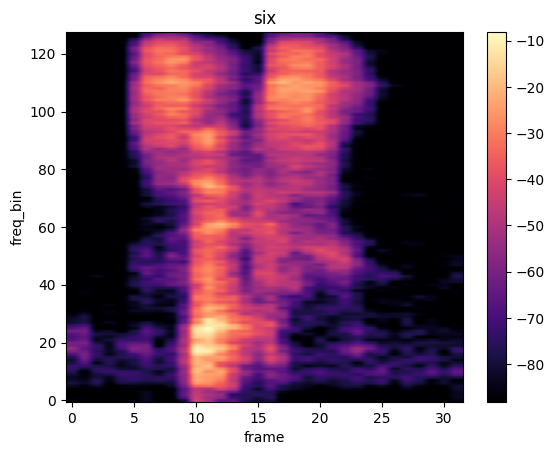

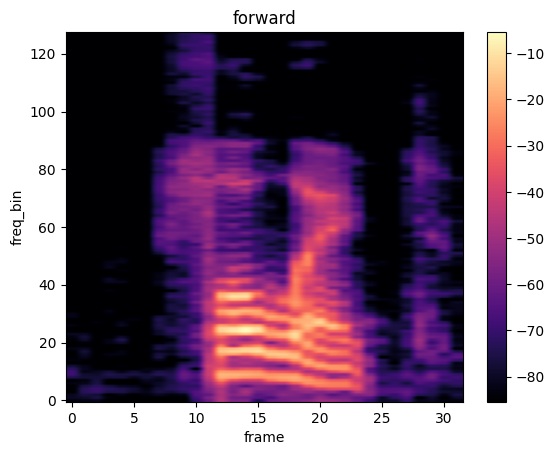

In [8]:
from src.plot import plot_spectrogram

ds = SpeechCommandDataset(batch_size=4)
for ar_mel_spec, label in ds.train_dl():
    for ar, l in zip(ar_mel_spec, label):
        plot_spectrogram(ar[0], title=ds.classes[l])
    break

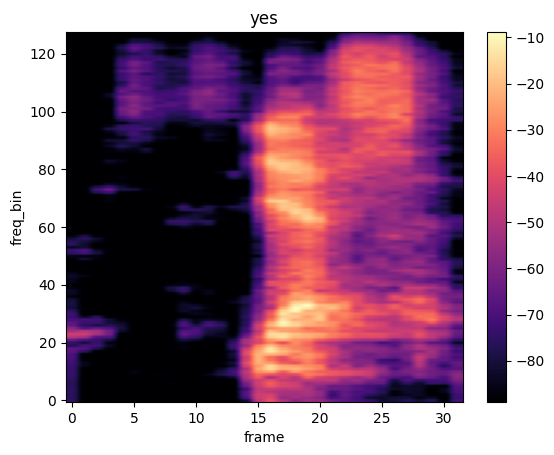

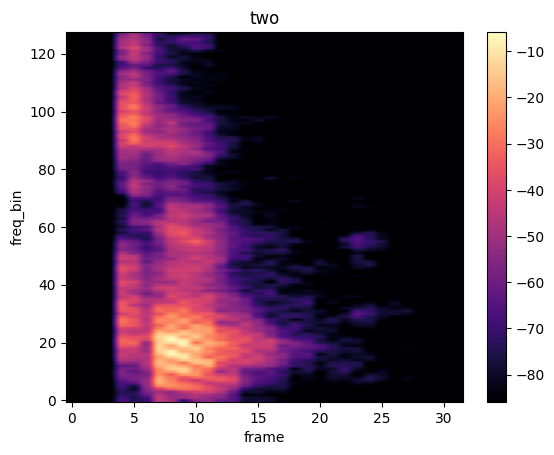

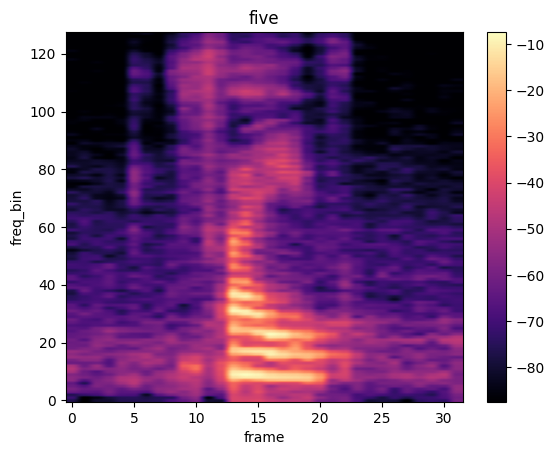

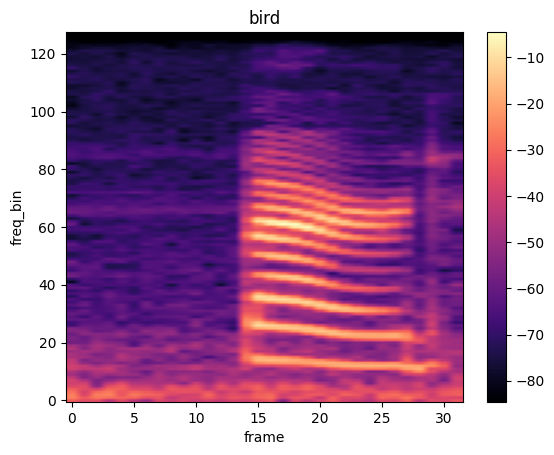

In [7]:
from dataclasses import dataclass

import torch
from torch.nn.functional import pad
from torch.utils.data import DataLoader
from torchaudio.datasets import SPEECHCOMMANDS
from torchaudio.transforms import MelSpectrogram


@dataclass
class SpeechCommandDataset:
    seq_size: int = 16000
    batch_size: int = 2
    mel_bins: int = 32
    n_fft: int = 1024

    classes = ('backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go',
               'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven',
               'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero')

    def __post_init__(self):
        self.mel_spectrogram = MelSpectrogram(
            sample_rate=self.seq_size,
            n_fft=self.n_fft,
            center=True,
            pad_mode="reflect",
            power=2.0,
            normalized=True,
            norm="slaney",
            n_mels=self.mel_bins,
            mel_scale="htk",
        )

    def preprocess_batch(self):
        def collate_fn(batch,
                       seq_size=self.seq_size,
                       mel_spectrogram=self.mel_spectrogram,
                       classes=self.classes):
            ars_mel_spec = []
            ars_label = []

            for b in batch:
                ar_audio = pad(b[0], [0, seq_size - b[0].shape[-1]], 'constant')
                ar_mel_spec = mel_spectrogram(ar_audio)
                ars_mel_spec.append(ar_mel_spec)
                ars_label.append([classes.index(b[2])])

            return torch.stack(ars_mel_spec), torch.tensor(ars_label, dtype=torch.long)

        return collate_fn

    def train_dl(self, download: bool = False):
        train_ds = SPEECHCOMMANDS("data/", download=download, subset="training")
        return DataLoader(train_ds,
                          batch_size=self.batch_size,
                          collate_fn=self.preprocess_batch(),
                          shuffle=True)

    def val_dl(self, download: bool = False):
        val_ds = SPEECHCOMMANDS("data/", download=download, subset="validation")
        return DataLoader(val_ds,
                          batch_size=self.batch_size,
                          collate_fn=self.preprocess_batch())

    def test_dl(self, download: bool = False):
        test_ds = SPEECHCOMMANDS("data/", download=download, subset="testing")
        return DataLoader(test_ds,
                          batch_size=self.batch_size,
                          collate_fn=self.preprocess_batch())

    def dls(self, download: bool = False):
        return self.train_dl(download), self.val_dl(download), self.test_dl(download)


ds = SpeechCommandDataset(batch_size=4, mel_bins=128)
for ar_mel_spec, label in ds.train_dl():
    for ar, l in zip(ar_mel_spec, label):
        plot_spectrogram(ar[0], title=ds.classes[l])
    break